In [1]:
import pandas as pd 
import numpy as np 
import ta
from backtester import *

In [2]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [3]:
bb = ta.volatility.BollingerBands(close=data['close'], window=20, window_dev=2, fillna=False)
data['bb_high'] = bb.bollinger_hband()
data['bb_avg'] = bb.bollinger_mavg()
data['bb_low'] = bb.bollinger_lband()
data.dropna(inplace=True)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close,bb_high,bb_avg,bb_low
date,,,,,,,,,,,,,,,,
2021-07-21 14:10:00,1.17856,1.17840,1.17887,1.17838,1.17868,1.17852,1.17899,1.17851,1619,1.178620,1.178930,1.178445,1.178460,1.179180,1.177274,1.175367
2021-07-21 14:15:00,1.17840,1.17850,1.17866,1.17831,1.17852,1.17863,1.17878,1.17842,1300,1.178460,1.178720,1.178365,1.178565,1.179323,1.177382,1.175442
2021-07-21 14:20:00,1.17850,1.17864,1.17892,1.17848,1.17863,1.17876,1.17904,1.17860,1183,1.178565,1.178980,1.178540,1.178700,1.179458,1.177502,1.175546
2021-07-21 14:25:00,1.17864,1.17885,1.17937,1.17861,1.17876,1.17898,1.17949,1.17872,1495,1.178700,1.179430,1.178665,1.178915,1.179568,1.177647,1.175727
2021-07-21 14:30:00,1.17885,1.17890,1.17929,1.17868,1.17898,1.17902,1.17940,1.17880,2324,1.178915,1.179345,1.178740,1.178960,1.179691,1.177774,1.175856


(9981, 16)


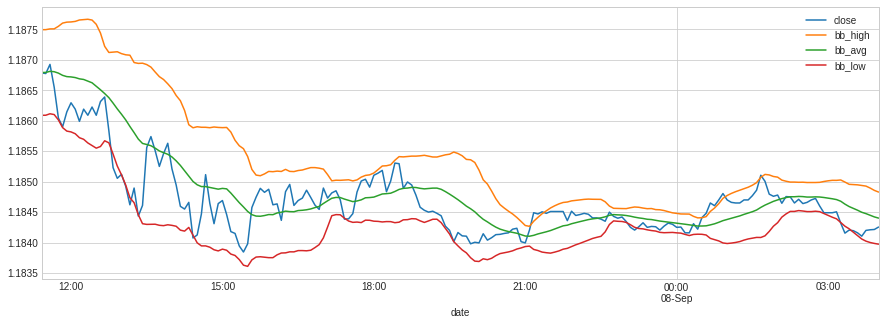

In [4]:
data[['close', 'bb_high', 'bb_avg', 'bb_low']].iloc[-200:].plot(figsize=(15,5))
plt.show()

In [5]:
data['distance'] = data['close'] - data['bb_avg']

In [6]:
data['bb_signal'] = np.where(data['close'] < data['bb_low'], 1,
                             np.where(data['close'] > data['bb_high'], -1, 
                                      np.where(data['distance']*data['distance'].shift(1)<0, 0, np.nan)))

In [7]:
data['bb_signal'] = data['bb_signal'].ffill().fillna(0)

In [8]:
print('Positions')
print(data['bb_signal'].value_counts())
print('-'*50)
print('Positions change')
print(data['bb_signal'].diff(1).apply(np.abs).value_counts())

Positions
 0.0    5171
-1.0    2547
 1.0    2263
Name: bb_signal, dtype: int64
--------------------------------------------------
Positions change
0.0    9249
1.0     717
2.0      14
Name: bb_signal, dtype: int64


In [9]:
backtest = IterativeBacktester(data, data['bb_signal'], 'm5')

In [10]:
backtest.backtest()

  0%|          | 0/9980 [00:00<?, ?it/s]

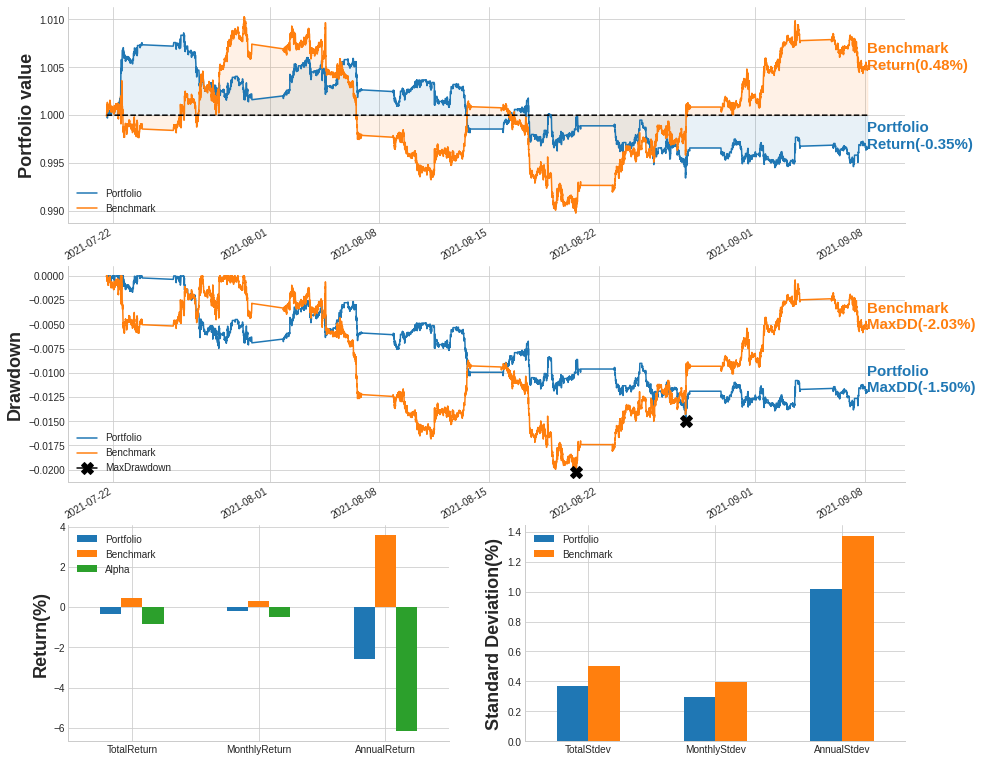

--------------------------------------------------
Data length: |48 days 13:50:00|
Data range from |2021-07-21 14:10:00| to |2021-09-08 04:00:00|
--------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -0.347 │       0.477 │  -0.823 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -0.217 │       0.298 │  -0.515 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      -2.604 │       3.581 │  -6.185 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │       0.372 │       0.501 │
├─────────────

In [11]:
backtest.results()